# Using historical data and machine learning with health insurance customer segmentation

## In scope

* Choosing and justifying train / test / validate splits
* High level decision on what family of ML algorithms are suitable for business task
* Quantifying impact on subpopulations

## Out of scope

* Rigorous EDA
* Pretty plots
* Rigorous feature selection and engineering
* Rigorous model selection


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


In [2]:
def target_eda(target_values: pd.Series) -> None:
    print(target_values.describe())
    target_values.plot.box();

    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

    axs[0].hist(target_values, bins=10)
    axs[1].hist(target_values, bins=50)
    sns.kdeplot(target_values, ax=axs[2], fill=True)
    
    plt.show()

## Load entire data available

In [3]:
project_root = Path('.') / '..' / '..'
data_dir = project_root / 'data'
notebooks_dir = project_root / 'notebooks'
eda_out_dir = notebooks_dir / 'eda-output'
eda_out_dir.mkdir(exist_ok=True)


customer_df = pd.read_csv(data_dir / 'simplified-customer-health.csv')
claims_df = pd.read_csv(data_dir / 'aggregate-claim-1.csv')  # use claims data post duplication error fix

X_y_raw_df = pd.merge(customer_df, claims_df, on='customer_id', how='left')
X_y_raw_df.head()

,customer_id,height,weight,occupation_group_idx,gender_idx,skin_cancer,depression,agg_claim_amount,year
0,0,162.29231,83.763466,3,0,0.0,0.0,10.26,2022
1,0,162.29231,83.763466,3,0,0.0,0.0,0.04,2023
2,0,162.29231,83.763466,3,0,0.0,0.0,580.92,2024
3,1,136.25010,53.333600,2,0,0.0,0.0,0.00,2022
4,1,136.25010,53.333600,2,0,0.0,0.0,0.02,2023


## Decide on train / validate / test split methodology

Using statistical and business logic considerations.

In [4]:
# Combine train / validation, as sample size small enough to justify k-fold cross validation

test_mask = X_y_raw_df['year'] == '2024'

train_raw_df = X_y_raw_df.loc[~test_mask, :]
test_raw_df = X_y_raw_df.loc[test_mask, :]

## Task

1. What assumptions are we making with this train / test / validate split methodology?
1. What are potential weaknesses of this assumption?
1. What are other approaches to consider, explore and document?

## A solution

1. We assume that the same customer from year to year is an independent, identically distributed random variable.
1. An individual in year $y$ is typically not independent of the same individual in year $y-1$.
1. A Markov chain could potentially explicitly model that records in the data splits correspond to individuals who are not necessarily indepenent from previous years.

## Explore target, `agg_claim_amount`

count    6.327000e+03
mean     5.833294e+04
std      2.563533e+06
min      0.000000e+00
25%      1.000000e-02
50%      5.100000e-01
75%      2.183000e+01
max      2.002250e+08
Name: agg_claim_amount, dtype: float64


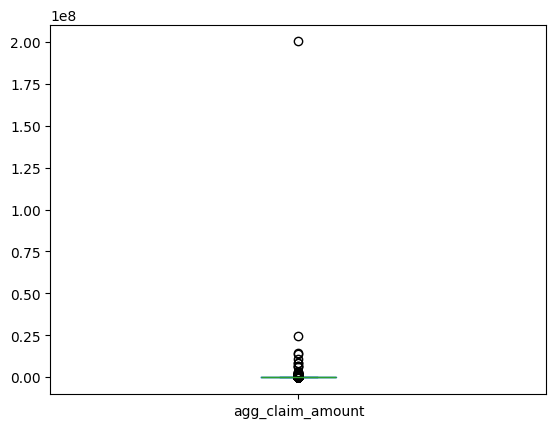

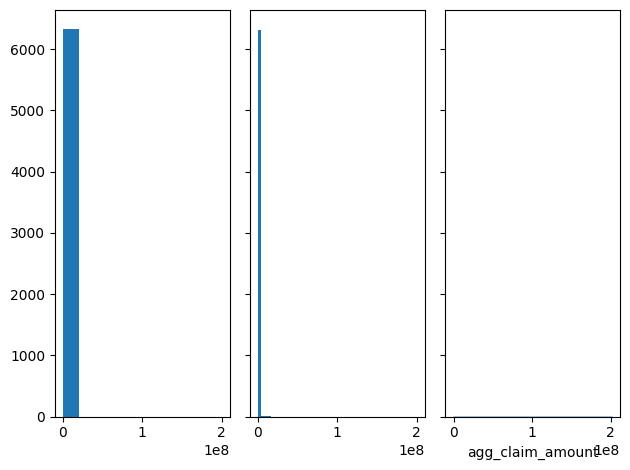

In [5]:
TARGET_COL = 'agg_claim_amount'
target_eda(train_raw_df[TARGET_COL])

count    6327.000000
mean        2.024128
std         2.978846
min         0.000000
25%         0.009950
50%         0.412110
75%         3.128075
max        19.114952
Name: agg_claim_amount, dtype: float64


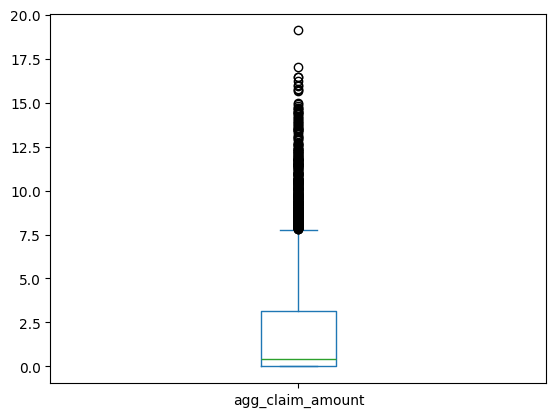

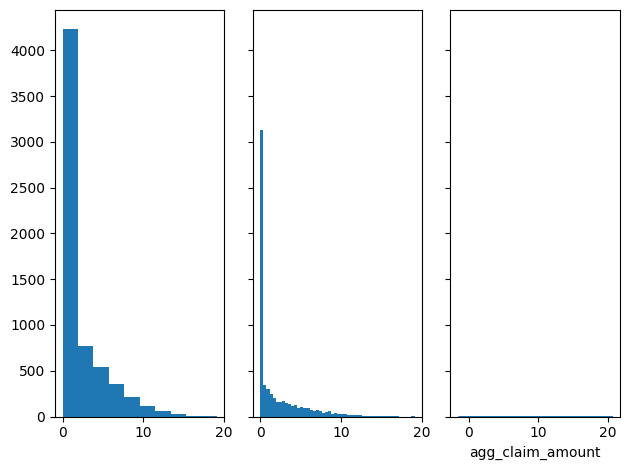

In [6]:
# Consider log-transformed data
y_train_transformed = np.log(train_raw_df[TARGET_COL] + 1)

target_eda(y_train_transformed)

## Task

What are reasons for and against splitting data into train / validation / tests before doing feature selection and engineering?

## A solution

* For: EDA, such as correlation analyses, can result in data leakage if done on the entire available historical data
* For: Splitting data can surface incorrect assumptions, such as valid values for a given field
* Against: It requires discipline and some additional work

## Task

Customer segementation is often approached as an unsupervised ML problem.

1. How could we approach our segmentation problem using an unsupervised approach, e.g. clustering algorithms?
1. Are there any technical restrictions on which fields we may not used? Please justify your answer.
1. What are some general pros and cons of clustering for this use-case?

## A solution

1. We could use clustering, but only on fields available at the time of inference, which excluded claim data, the target of our supervised approach.
1. Claims data is not available at the time of inference, as the new customer does not have any claims with the insurance customer yet.
1. With clustering, it's important to decide up and justify issues like
    * how many clusters?
    * what do the clusters mean?

In regulated AI, a significant con is the 2nd point, as technical teams have to understand and be able to document for and train the deployers (people using the segmentation model) the clusters in terms of business semantics.